In [1]:
import sentencepiece as spm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

### 1. Load vocabulary model

In [2]:
vocab_model = '../data/kowiki.model'
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_model)

True

In [3]:
examples = ['내일은 비가 오네요.',
              '오늘은 날씨가 좋네요.']


In [4]:
vocab_list = []
for example in examples:
    pieces = vocab.encode_as_pieces(example)
    print(pieces)
    ids = vocab.encode_as_ids(example)
    print(ids)
    vocab_list.append(torch.tensor(ids))
    

['▁내', '일은', '▁비', '가', '▁오', '네', '요', '.']
[114, 2979, 78, 3496, 64, 3753, 3656, 3487]
['▁오늘', '은', '▁날', '씨', '가', '▁좋', '네', '요', '.']
[1597, 3501, 691, 3924, 3496, 776, 3753, 3656, 3487]


In [5]:
# 문장마다 길이가 다르기 때문에 생기는 차이는 `pad(0)`으로 채워준다.
inputs = torch.nn.utils.rnn.pad_sequence(vocab_list, \
                                 batch_first=True, padding_value=0)

print(inputs)
print(inputs.size())

tensor([[ 114, 2979,   78, 3496,   64, 3753, 3656, 3487,    0],
        [1597, 3501,  691, 3924, 3496,  776, 3753, 3656, 3487]])
torch.Size([2, 9])


### 2. Embedding

모델이 해석할 수 있는 입력값으로 매핑해주는 역할을 한다. 이 때, **Transformer**의 `embedding`은 다음과 같이 두 가지를 합해서 사용한다.

* Input Embedding
* Positional Embedding

#### 2-1. Input embedding

In [6]:
num_vocabs = len(vocab)
print(num_vocabs)
dim_hidn = 128 # 데이터를 어느 정도의 길이/차원으로 바꿔줄지를 선택
nn_embed = nn.Embedding(num_vocabs, dim_hidn)

inputs_embed = nn_embed(inputs)
print(inputs_embed.size())

8007
torch.Size([2, 9, 128])


#### 2-2. Positional embedding

- 각 position별 angle 값 구하기.
- 구해진 angle 중 짝수 index의 값에 대한 sin 적용
- 구해진 angle 중 홀수 index의 값에 대한 cos 적용

In [7]:
def positional_encoding(num_seq, dim_hidn):

    def cal_angle(pos, idx_hidn):
        return pos/np.power(10000, \
                            2*(idx_hidn//2)/dim_hidn)
    
    def get_pos_angle(pos):
        return [cal_angle(pos, idx_hidn) for idx_hidn \
                                            in range(dim_hidn)]
    
    sinusoid_table = np.array([get_pos_angle(i_seq) for \
                                           i_seq in range(num_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

(64, 128)


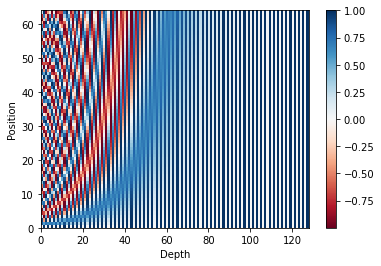

In [9]:
num_seqs = 64
pos_encoding = positional_encoding(num_seqs, dim_hidn)

print (pos_encoding.shape)
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, dim_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

위의 그래프에서 알 수 있듯이, position마다 주기(depth)가 다르므로 서로 다른 값으로 매핑되는 것을 확인할 수 있다. 

position embedding을 위한 position encoding lookup table이 만들어졌으므로 이를 활용하여 입력값에서의 위치에 맞는 embedding값을 대응하기 위해서 nn.Embedding의 weight로 적용시킨다.

In [10]:
# 1. 앞서 구한 pos_encoding의 table을 nn.Embedding으로 하여 positional embedding을 하는 함수를 만들어준다.
# 이 때, 학습되는 값이 아니므로 `freeze=True`로 한다.
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos_embed = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

In [11]:
# 2. 주어진 입력값의 vocab마다의 순서/위치를 나타내는 vector를 만든다.
pos = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(\
                                                          inputs.size(0), inputs.size(1)).contiguous() + 1
pos

tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [12]:
# 3. 앞서 구한 position에서 입력값의 <pad>에 해당하는 부분은 사용하지 않도록 mask를 만든다.
pos_mask = inputs.eq(0) # 0과 같으면 True, 아니면 False
pos_mask

tensor([[False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False]])

In [13]:
# 4. mask를 적용한 pos 벡터를 통해서 position embedding을 구한다.
pos.masked_fill_(pos_mask, 0) # mask의 True인 위치의 값만 0으로 대체 
pos_embed = nn_pos_embed(pos) # position embedding

print(inputs)
print(pos)
print(pos_embed.size())

tensor([[ 114, 2979,   78, 3496,   64, 3753, 3656, 3487,    0],
        [1597, 3501,  691, 3924, 3496,  776, 3753, 3656, 3487]])
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 0],
        [1, 2, 3, 4, 5, 6, 7, 8, 9]])
torch.Size([2, 9, 128])


In [14]:
inputs_pos_embed = inputs_embed + pos_embed

### 3. Scaled dot production attention

<img src='../imgs/dot_production_attn.png' width=500>

위와 같이 입력값은 `Q`, `K`, `V`, `attention mask`로 구성되어 있고, `K`와 `V`는 값은 값이어야 한다. 이 때, `Q, K, V`가 모두 동일하다면 **self-attention**이라고 한다.

In [18]:
# 1. MatMul
Q = inputs_pos_embed
K= inputs_pos_embed
V = inputs_pos_embed
# attn_mask의 shape은 Q와 K의 matmul한 이후의 shape와 동일해야한다.
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(Q.size())
print(inputs.size())
print(attn_mask.size())
print(attn_mask)

torch.Size([2, 9, 128])
torch.Size([2, 9])
torch.Size([2, 9, 9])
tensor([[[False, False, False, False, False, False, False, False,  True],
         [False, False, False, False, False, False, False, False,  True],
         [False, False, False, False, False, False, False, False,  True],
         [False, False, False, False, False, False, False, False,  True],
         [False, False, False, False, False, False, False, False,  True],
         [False, False, False, False, False, False, False, False,  True],
         [False, False, False, False, False, False, False, False,  True],
         [False, False, False, False, False, False, False, False,  True],
         [False, False, False, False, False, False, False, False,  True]],

        [[False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, 

In [19]:
scores = torch.matmul(Q, K.transpose(-1, -2)) # 또는 K.transpose(1, 2)도 동일
print(scores.size())
print(scores)

torch.Size([2, 9, 9])
tensor([[[239.8143,  82.1622,  60.1543,  48.2025,  74.3388,  64.4771,  68.2597,
           43.4250,  91.3062],
         [ 82.1622, 222.6051,  68.1487,  83.6456,  53.8603,  85.1838,  87.8367,
           33.1051,  89.9340],
         [ 60.1543,  68.1487, 208.5611,  48.2173,  62.8902,  37.6314,  38.1449,
           50.2315,  89.2248],
         [ 48.2025,  83.6456,  48.2173, 166.4888,  58.7092,  71.3033,  64.9827,
           26.7374,  56.8726],
         [ 74.3388,  53.8603,  62.8902,  58.7092, 188.9280,  33.8017,  74.4620,
           22.5769,  70.2024],
         [ 64.4771,  85.1838,  37.6314,  71.3033,  33.8017, 204.8648,  70.9715,
           23.5115,  34.5963],
         [ 68.2597,  87.8367,  38.1449,  64.9827,  74.4619,  70.9715, 170.7333,
           30.3466,  61.0817],
         [ 43.4250,  33.1051,  50.2315,  26.7374,  22.5769,  23.5115,  30.3466,
          146.7108,  30.0690],
         [ 91.3062,  89.9340,  89.2248,  56.8726,  70.2024,  34.5963,  61.0817,
          

In [26]:
# 2. Scale
dim_head = 64
scores = scores.mul_(1/dim_head**0.5)
print(scores.size())
print(scores)

torch.Size([2, 9, 9])
tensor([[[ 3.7471e+00,  1.2838e+00,  9.3991e-01,  7.5316e-01,  1.1615e+00,
           1.0075e+00,  1.0666e+00,  6.7852e-01, -1.2500e+08],
         [ 1.2838e+00,  3.4782e+00,  1.0648e+00,  1.3070e+00,  8.4157e-01,
           1.3310e+00,  1.3724e+00,  5.1727e-01, -1.2500e+08],
         [ 9.3991e-01,  1.0648e+00,  3.2588e+00,  7.5340e-01,  9.8266e-01,
           5.8799e-01,  5.9601e-01,  7.8487e-01, -1.2500e+08],
         [ 7.5316e-01,  1.3070e+00,  7.5340e-01,  2.6014e+00,  9.1733e-01,
           1.1141e+00,  1.0154e+00,  4.1777e-01, -1.2500e+08],
         [ 1.1615e+00,  8.4157e-01,  9.8266e-01,  9.1733e-01,  2.9520e+00,
           5.2815e-01,  1.1635e+00,  3.5276e-01, -1.2500e+08],
         [ 1.0075e+00,  1.3310e+00,  5.8799e-01,  1.1141e+00,  5.2815e-01,
           3.2010e+00,  1.1089e+00,  3.6737e-01, -1.2500e+08],
         [ 1.0666e+00,  1.3724e+00,  5.9601e-01,  1.0154e+00,  1.1635e+00,
           1.1089e+00,  2.6677e+00,  4.7417e-01, -1.2500e+08],
         [ 6

> dim_head?????????????????????????

In [22]:
# 3. Mask opt.
# 매우 작은 숫자로 해주어야 softmax를 통해서 확률로 바꿀 때 0이 된다.
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores)

torch.Size([2, 9, 9])
tensor([[[ 2.9977e+01,  1.0270e+01,  7.5193e+00,  6.0253e+00,  9.2924e+00,
           8.0596e+00,  8.5325e+00,  5.4281e+00, -1.0000e+09],
         [ 1.0270e+01,  2.7826e+01,  8.5186e+00,  1.0456e+01,  6.7325e+00,
           1.0648e+01,  1.0980e+01,  4.1381e+00, -1.0000e+09],
         [ 7.5193e+00,  8.5186e+00,  2.6070e+01,  6.0272e+00,  7.8613e+00,
           4.7039e+00,  4.7681e+00,  6.2789e+00, -1.0000e+09],
         [ 6.0253e+00,  1.0456e+01,  6.0272e+00,  2.0811e+01,  7.3387e+00,
           8.9129e+00,  8.1228e+00,  3.3422e+00, -1.0000e+09],
         [ 9.2924e+00,  6.7325e+00,  7.8613e+00,  7.3387e+00,  2.3616e+01,
           4.2252e+00,  9.3077e+00,  2.8221e+00, -1.0000e+09],
         [ 8.0596e+00,  1.0648e+01,  4.7039e+00,  8.9129e+00,  4.2252e+00,
           2.5608e+01,  8.8714e+00,  2.9389e+00, -1.0000e+09],
         [ 8.5325e+00,  1.0980e+01,  4.7681e+00,  8.1228e+00,  9.3077e+00,
           8.8714e+00,  2.1342e+01,  3.7933e+00, -1.0000e+09],
         [ 5

In [23]:
# 4. Softmax
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob)

torch.Size([2, 9, 9])
tensor([[[1.0000e+00, 2.7642e-09, 1.7654e-10, 3.9628e-11, 1.0396e-09,
          3.0304e-10, 4.8624e-10, 2.1810e-11, 0.0000e+00],
         [2.3758e-08, 1.0000e+00, 4.1215e-09, 2.8598e-08, 6.9086e-10,
          3.4661e-08, 4.8290e-08, 5.1600e-11, 0.0000e+00],
         [8.7794e-09, 2.3848e-08, 1.0000e+00, 1.9745e-09, 1.2359e-08,
          5.2574e-10, 5.6059e-10, 2.5397e-09, 0.0000e+00],
         [3.7896e-07, 3.1819e-05, 3.7967e-07, 9.9996e-01, 1.4092e-06,
          6.8024e-06, 3.0870e-06, 2.5901e-08, 0.0000e+00],
         [6.0162e-07, 4.6516e-08, 1.4382e-07, 8.5278e-08, 1.0000e+00,
          3.7904e-09, 6.1095e-07, 9.3181e-10, 0.0000e+00],
         [2.3922e-08, 3.1835e-07, 8.3451e-10, 5.6153e-08, 5.1705e-10,
          1.0000e+00, 5.3872e-08, 1.4286e-10, 0.0000e+00],
         [2.7354e-06, 3.1607e-05, 6.3413e-08, 1.8160e-06, 5.9390e-06,
          3.8391e-06, 9.9995e-01, 2.3924e-08, 0.0000e+00],
         [2.4714e-06, 6.8031e-07, 5.7869e-06, 3.0692e-07, 1.8246e-07,
     

In [24]:
# 5. Matmul
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 9, 128])


위의 과정들을 하나의 class로 바꾸어 보자.

In [27]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

### 4. Multi-head attention

<img src='../imgs/multi_head_attn.png' width=500>

> multi-head attention을 사용하는 이유는 무엇일까????????????????????

> Linear를 하는 이유는???? activation을 하는 것도 아닌데???

In [28]:
Q = inputs_pos_embed
K = inputs_pos_embed
V = inputs_pos_embed
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
num_heads = 2
print(batch_size)

2


> batch_size = Q.size(0)???? 문장의 개수?????

> num_heads = 2인 이유는 dim_head = 64로 embedding size = 128을 나누어서?  >> YES

> 그렇다면, 단순히 한번에 계산할 수 있는 것을 두 번으로 나누어서 계산??? 하는 이유는???

In [30]:
# 1, 2, 3. Q, K, V를 여러 개의 head로 나눈다.
W_Q = nn.Linear(dim_hidn, num_heads * dim_head)
W_K = nn.Linear(dim_hidn, num_heads * dim_head)
W_V = nn.Linear(dim_hidn, num_heads * dim_head)

# (bs, n_seq, n_head * d_head)
q_s = W_Q(Q)
print(Q.size(), q_s.size())
# (bs, n_seq, n_head, d_head)
q_s = q_s.view(batch_size, -1, num_heads, dim_head)
print(q_s.size())
# (bs, n_head, n_seq, d_head)
q_s = q_s.transpose(1,2)
print(q_s.size())

torch.Size([2, 9, 128]) torch.Size([2, 9, 128])
torch.Size([2, 9, 2, 64])
torch.Size([2, 2, 9, 64])


이를 한 줄로 표현하면, 

In [31]:
# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, num_heads, dim_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, num_heads, dim_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, num_heads, dim_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())


torch.Size([2, 2, 9, 64]) torch.Size([2, 2, 9, 64]) torch.Size([2, 2, 9, 64])


In [32]:
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, num_heads, 1, 1)
print(attn_mask.size())

torch.Size([2, 9, 9])
torch.Size([2, 2, 9, 9])


In [37]:
# 4. attention
scaled_dot_attn = ScaledDotProductAttention(dim_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 9, 64])
torch.Size([2, 2, 9, 9])


In [39]:
# 5. concat
# (bs, n_seq, n_head * d_head)
context = context.transpose(1, 2).contiguous().view(\
                        batch_size, -1, num_heads * dim_head)
print(context.size())

torch.Size([2, 9, 128])


In [40]:
linear = nn.Linear(num_heads * dim_head, dim_hidn)
# (bs, n_seq, d_hidn)
output = linear(context)
print(output.size())

torch.Size([2, 9, 128])


위으 모든 과정을 하나의 class로 만들어 보자.

In [41]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

### 5. Masked multi-head attention

Masked Multi-Head Attention은 Multi-Head Attention과 attention mask를 제외한 부분은 모두 동일하다.

In [43]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


Q = inputs_pos_embed
K = inputs_pos_embed
V = inputs_pos_embed

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[1])
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[1])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[1])

batch_size = Q.size(0)
n_head = 2


tensor([[False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([

In [45]:
attention = MultiHeadAttention(dim_hidn, num_heads, dim_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 9, 128]) torch.Size([2, 2, 9, 9])


## FeedForwad

<img src='../imgs/feedforward.png' width=500>

In [50]:
# 1. f_1
conv1 = nn.Conv1d(in_channels=dim_hidn, \
                  out_channels=dim_hidn*4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
f_1 = conv1(output.transpose(1, 2))
print(f_1.size())

torch.Size([2, 512, 9])


In [55]:
# 2. f_2: activation
# active = F.relu
acitvn = F.gelu
f_2 = acitvn(f_1)

In [56]:
# 3. f_3
conv2 = nn.Conv1d(in_channels=dim_hidn * 4, \
                  out_channels=dim_hidn, kernel_size=1)
f_3 = conv2(f_2).transpose(1, 2)
print(f_3.size())

torch.Size([2, 9, 128])


In [57]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, \
                               out_channels=self.config.d_hidn*4,\
                               kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn*4,\
                               out_channels=self.config.d_hidn,\
                               kernel_size=1)
        self.activn = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.activn(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output

In [58]:
""" encoder """
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)

        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

In [59]:
""" decoder layer """
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

In [60]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

In [61]:
""" transformer """
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs